In [374]:
import sys, os
import qp
import numpy as np
from scipy import linalg as sla
from scipy import special
from scipy import integrate as sciint
from scipy import interpolate as sciinterp
from matplotlib import pylab as plt
from astropy.io import fits as pf
%matplotlib inline
%config Completer.use_jedi = False

We load the data : pdf examples from either qp or the original SparsePz package

In [364]:
Ntot = 10 #limit the number of pdfs for testing. Set to -1 to load all pdfs
if True:
    filein = '/home/cohen/lsst/codes/pipelines/photoz/SparsePz/CFHTLens_sample.P.npy'
    #FORMAT FILE, EACH ROW IS THE PDF FOR EACH GALAXY, LAST ROW IS THE REDSHIFT POSITION
    P = np.load(filein)
    z = P[-1]
    P = P[:Ntot]
else:
    ens = qp.read('qp_test_ensemble.hdf5')
    z = ens.metadata()['xvals'][0]
    if Ntot != -1:
        ens_red = ens[np.arange(Ntot)]
    else:
        ens_red = ens
    P = ens_red.objdata()['yvals']

We want to enforce normalisation, just in case the input pdfs are not properly normalized, and we want to optimize the grid used for sparse representation over the whole considered sample (the same grid needs to be used for every pdf in the sample). We use trapezoidal rule as a fast integrator and likely a sufficient precision for our purpose.

In [461]:
P = P/sciint.trapz(P,z).reshape(-1,1)

In [466]:
minz = np.min(z)
nz = 300
i,j=np.where(P>0)
maxz=np.max(z[j])
newz=np.linspace(minz, maxz, nz)
interp = sciinterp.interp1d(z,P, assume_sorted=True)
newpdf = interp(newz)
newpdf = newpdf / sciint.trapz(newpdf,newz).reshape(-1,1)

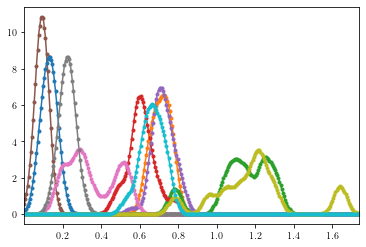

In [467]:
##check the pdf if the Ntot is not too large
plt.plot(z,P.T); plt.plot(newz,newpdf.T,'.'); plt.xlim(minz,maxz);

In [532]:
#Note : the range for gamma is fixed to [0, 0.5] in qp.utils.create_voigt_basis
def build_sparse_representation(z, P, mu=None, Nmu=None, sig=None, Nsig=None, Nv=3, Nsparse=20, tol=1.e-10):
    Ntot = len(P)
    print("Total Galaxies = ", Ntot)
    dz = z[1] - z[0]
    print('dz = ', dz)
    if mu is None:
        mu = [min(z), max(z)]
    if Nmu is None:
        Nmu = len(z)
    if sig is None:
        max_sig = (max(z) - min(z)) / 12.
        min_sig = dz / 6.
        sig = [min_sig, max_sig]
    if Nsig is None:
        Nsig = int(np.ceil(2. * (max_sig - min_sig) / dz))

    print('Nmu, Nsig, Nv = ', '[', Nmu, ',', Nsig, ',', Nv, ']')
    print('Total bases in dictionary', Nmu * Nsig * Nv)

    #Create dictionary
    print('Creating Dictionary...')
    A = qp.utils.create_voigt_basis(z, mu, Nmu, sig, Nsig, Nv)
    bigD = {}

    Nsparse = 20
    Ncoef = 32001
    AA = np.linspace(0, 1, Ncoef)
    Da = AA[1] - AA[0]

    print('Nsparse (number of bases) = ', Nsparse)

    bigD['z'] = z
    bigD['mu'] = mu
    bigD['sig'] = sig
    bigD['dims'] = [Nmu, Nsig, Nv, Ncoef]
    bigD['N_SPARSE'] = Nsparse
    bigD['Ntot'] = Ntot

    print('Creating Sparse representation...')

    for k in range(Ntot):
        bigD[k] = {}
        try:
            pdf0 = P[k]
        except:
            continue
        
        Dind, Dval = qp.utils.sparse_basis(A, pdf0, Nsparse, tolerance=tol)

        if len(Dind) <= 1: continue
        bigD[k]['sparse'] = [Dind, Dval]
        if max(Dval) > 0:
            dval0=Dval[0]
            Dvalm = Dval / np.max(Dval)
            index = np.array(list(map(round, (Dvalm / Da))), dtype='int')
            index0=int(round(dval0/Da))
            index[0]=index0
        else:
            index = np.zeros(len(Dind), dtype='int')

        bigD[k]['sparse_ind'] = np.array(list(map(combine_int, index, Dind)))
    
        #swap back columns
        A[:, [Dind]] = A[:, [np.arange(len(Dind))]]

    #For now, extend the representation into a full 2D array
    #This may be removed eventually
    ALL = np.zeros((Ntot, Nsparse), dtype='int')
    for i in range(Ntot):
        if i in bigD:
            idd = bigD[i]['sparse_ind']
            ALL[i, 0:len(idd)] = idd
    print('done')
    return ALL, bigD

In [533]:
ALL, bigD = build_sparse_representation(newz, newpdf)

Total Galaxies =  10
dz =  0.005810066889632109
Nmu, Nsig, Nv =  [ 300 , 50 , 3 ]
Total bases in dictionary 45000
Creating Dictionary...
Nsparse (number of bases) =  20
Creating Sparse representation...
done


Now, we use this representation to reconstruct a pdf, and compare to the original one. It is important to note that the sparse representation is *not* a functional representation : one need to start with the grid representation embedded in the sparse representation and interpolate, if one wants to use an arbitrary array of x values for subsequent use.

In [534]:
# First create the metadata, so that we have an interface similar 
#to what will be available when reading back a file.
meta = {}
#head['N_TOT'] = Ntot
meta['z'] = z
meta['Nmu'] = bigD['dims'][0]
meta['Nsig'] = bigD['dims'][1]
meta['Nv'] = bigD['dims'][2]
meta['Ncoef'] = bigD['dims'][3]
meta['N_SPARSE'] = bigD['N_SPARSE']
meta['mu'] = bigD['mu']
meta['sig'] = bigD['sig']

In [535]:
#Next decode the sparse indices into the voigt shape parameters
#The underlying code needs to be improved to avoid a for loop here
k=3
va, ma, sa, ga = qp.utils.indices2shapes(ALL[k], meta)

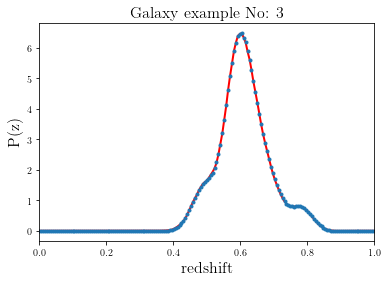

In [536]:
#newz=np.linspace(0.005,3.005,301)
#newz=np.linspace(0,1,500)
pdf = np.zeros_like(newz)
for v, m, s, g in zip(va,ma,sa,ga):
    pdft = special.voigt_profile(newz - m, s, g)
#    print(sciint.trapz(pdft,newz))
#    print(v)
#    print(sla.norm(pdft))
    pdft = np.where(pdft >= cut, pdft, 0.)
    pdft = v * pdft / sla.norm(pdft)
    #pdft = v * pdft
    pdf += pdft
pdf = pdf / sciint.trapz(pdf,newz)
#plt.plot(newz,pdf-newpdf[k],'r', linewidth=2)
plt.plot(newz,pdf,'r', linewidth=2)
plt.plot(newz,newpdf[k], '.')
plt.xlim(0,1)
title = 'Galaxy example No: %d' % k
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.title(title);


In [516]:
#writing to a fits file, as originally proposed in SparsePz
if False:
    print('Writing fits file (example_out.fits)')

    head = pf.Header()
    head['N_TOT'] = Ntot
    head['N_MU'] = bigD['dims'][0]
    head['N_SIGMA'] = bigD['dims'][1]
    head['N_VOIGT'] = bigD['dims'][2]
    head['N_COEF'] = bigD['dims'][3]
    head['N_SPARSE'] = bigD['N_SPARSE']
    head['MU1'] = bigD['mu'][0]
    head['MU2'] = bigD['mu'][1]
    head['SIGMA1'] = bigD['sig'][0]
    head['SIGMA2'] = bigD['sig'][1]

    col1 = pf.Column(name='redshift', format='E', array=bigD['z'])
    fmt = '%dJ' % bigD['N_SPARSE']
    col2 = pf.Column(name='Sparse_indices', format=fmt, array=ALL)
    table1 = pf.BinTableHDU.from_columns(pf.ColDefs([col1]))
    table2 = pf.BinTableHDU.from_columns(pf.ColDefs([col2]))
    prihdu = pf.PrimaryHDU(header=head)
    hdulist = pf.HDUList([prihdu, table1, table2])
    hdulist.writeto('example_out.fits', overwrite=True)
